In [45]:
import random
from multiprocessing import Pool
from os import makedirs, listdir
from os.path import isdir, join
from typing import Dict, List, Any, Tuple
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import scipy.io as sio
import numpy as np
import einops
from datasets.deap import DEAPDataset

In [46]:
from os.path import isdir
from os import mkdir
images_path = join("images")
if not isdir(images_path):
    makedirs(images_path)
    
scale = 4

In [47]:
dataset = DEAPDataset(path=join("..", "..", "datasets", "deap"), discretize_labels=True, normalize_eegs=True, window_size=1, window_stride=1)

In [48]:
from models.sateer import SATEER

model = SATEER(
        in_channels=len(dataset.electrodes),
        sampling_rate=dataset.sampling_rate,
        labels=dataset.labels,
        labels_classes=dataset.labels_classes,

        users_embeddings=True,
        num_users=len(dataset.subject_ids),

        mels=16,
        mel_window_size=0.5,
        mel_window_stride=0.25,

        hidden_size=512,
        num_encoders=4,
        num_decoders=4,
        encoder_only=False,
        num_attention_heads=8,
        positional_embedding_type="sinusoidal",
        max_position_embeddings=2048,
        dropout_p=0.25,
        data_augmentation=False,
    )

In [49]:
dataloader = DataLoader(dataset, batch_size=1, num_workers=4, shuffle=False)

torch.Size([1, 16, 6, 32])


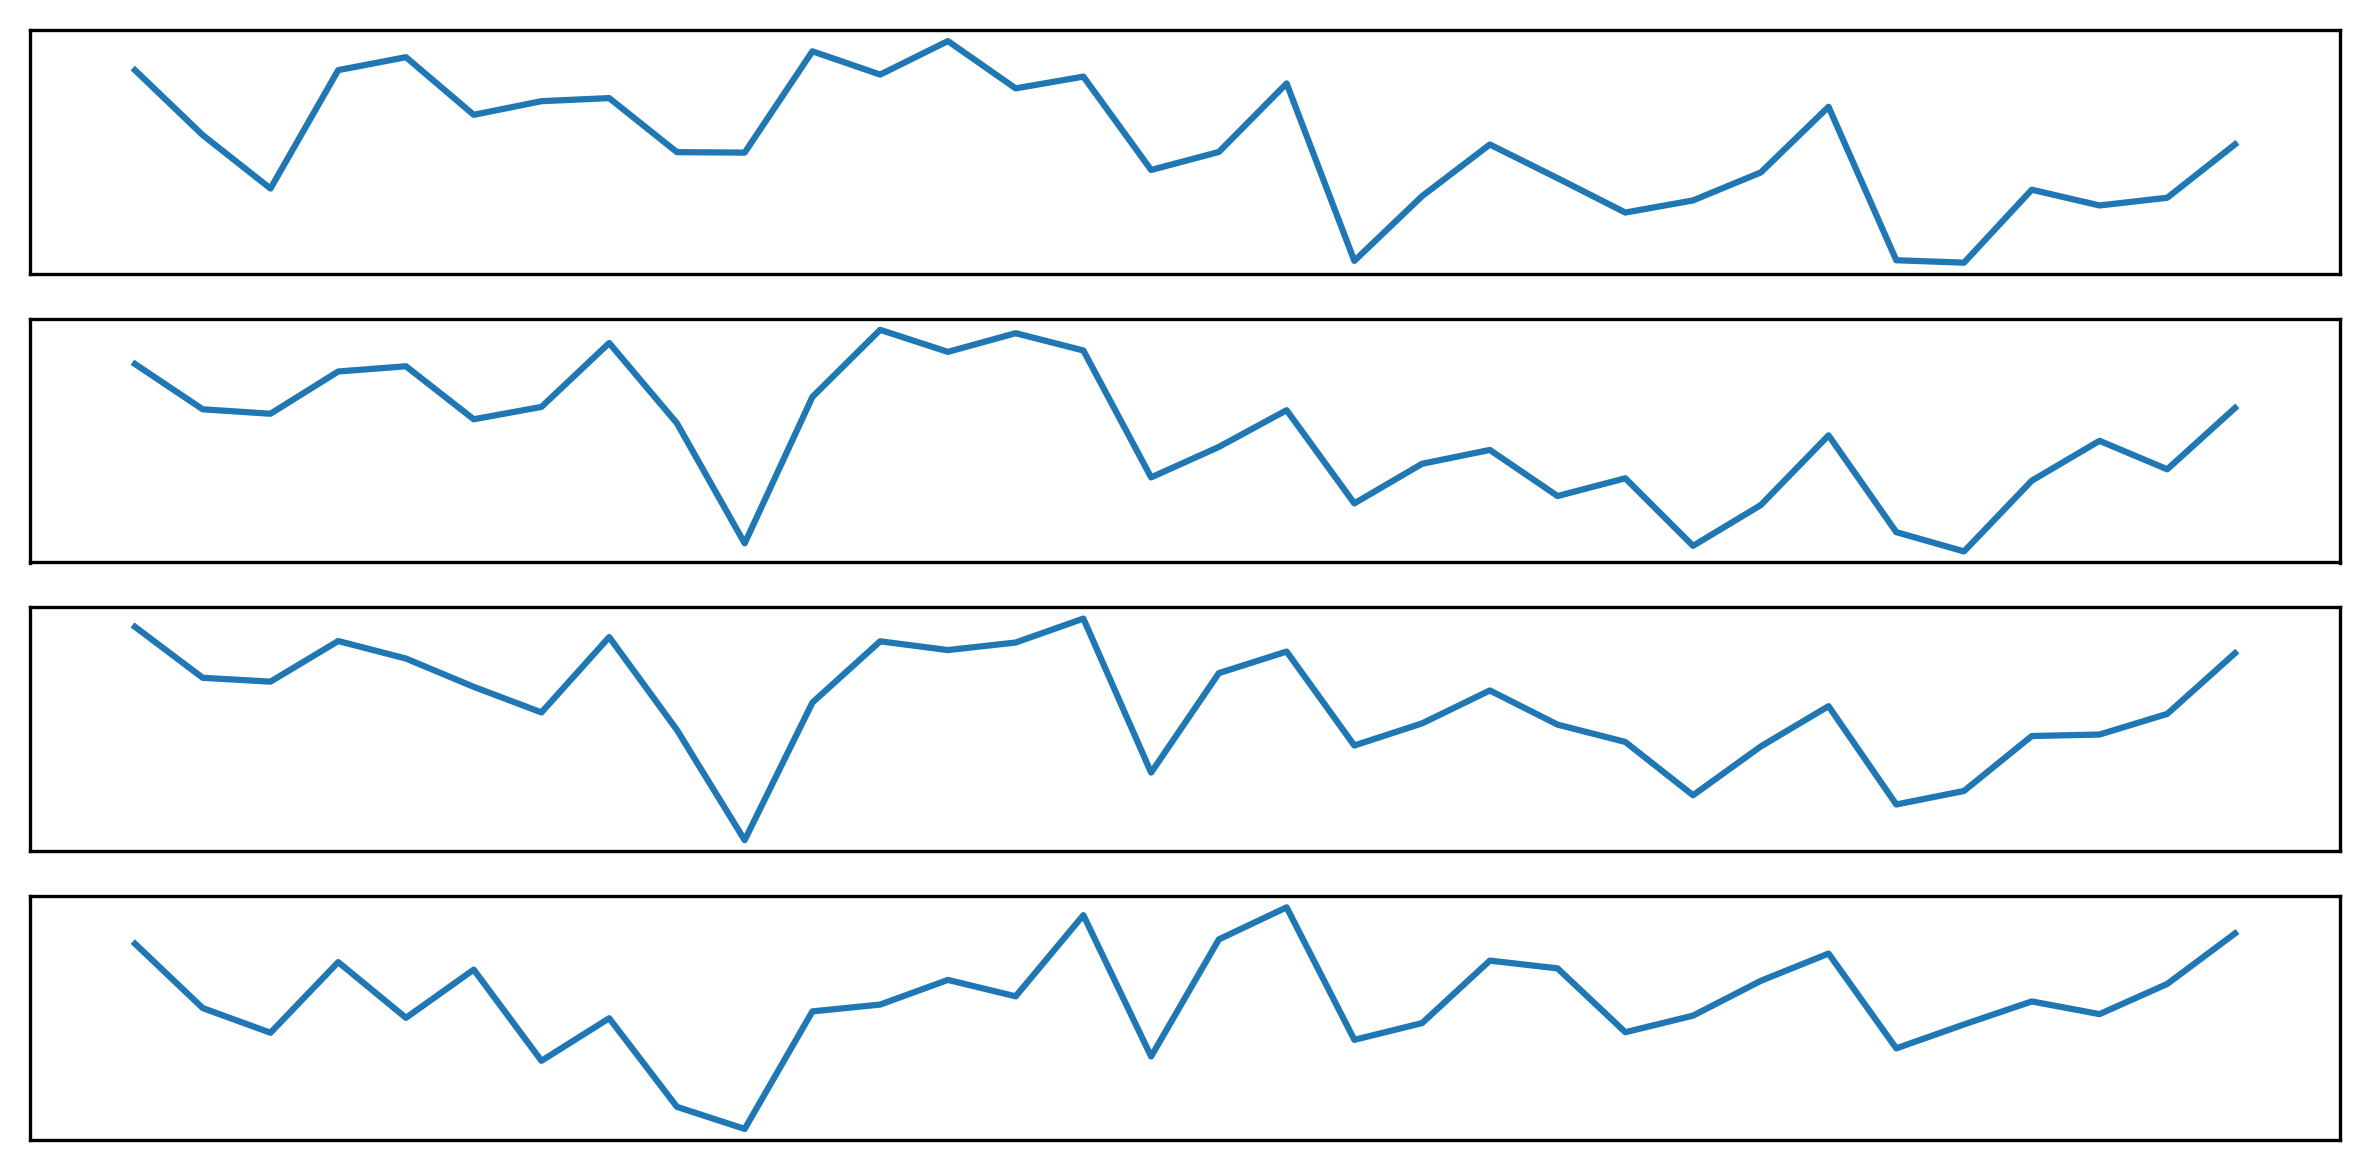

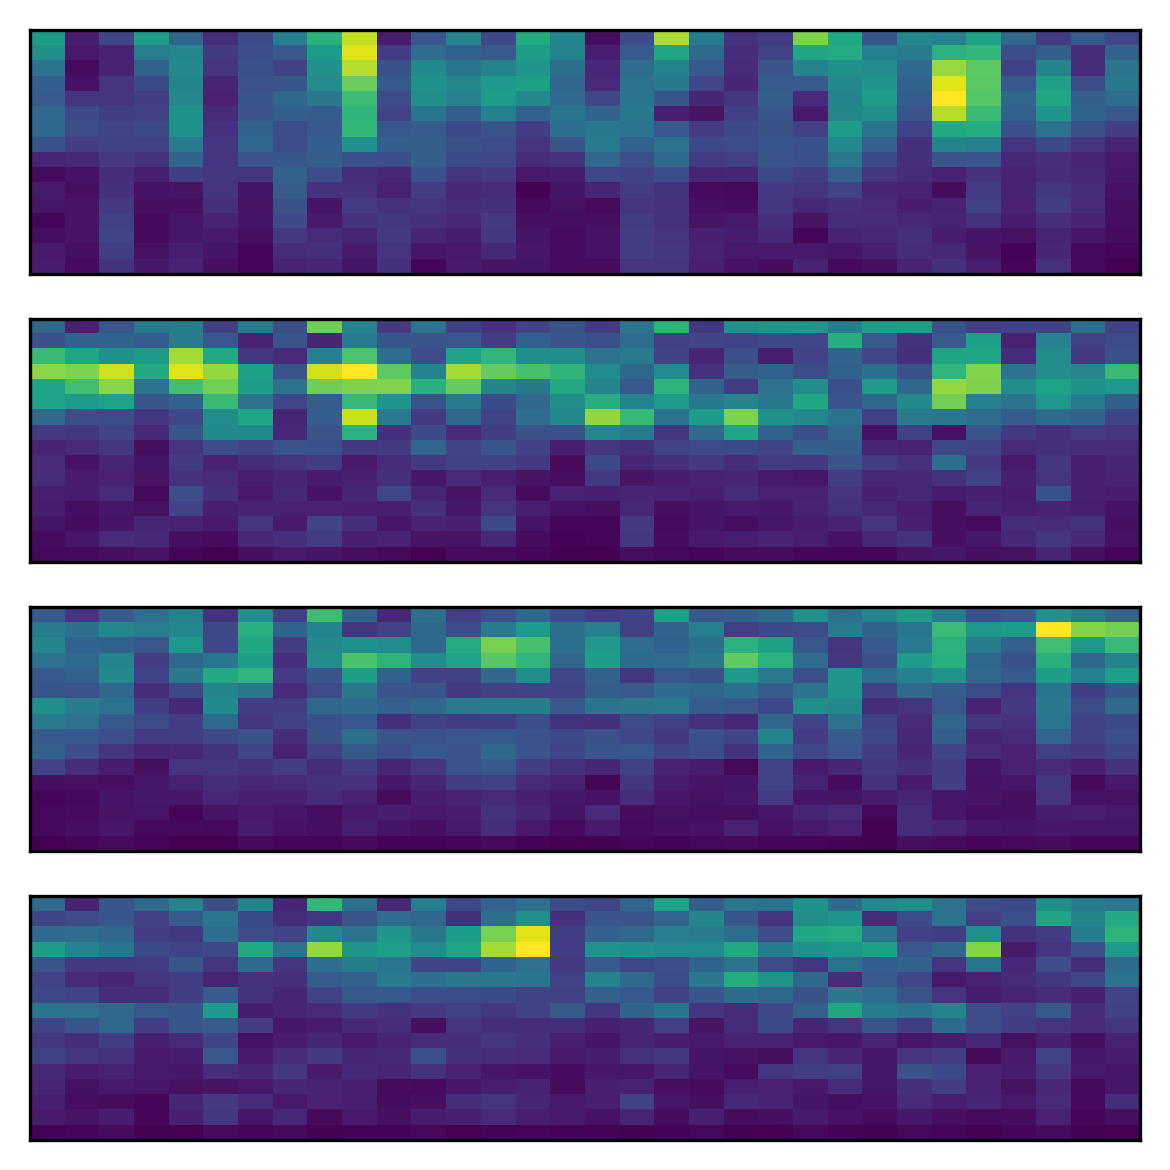

In [50]:
for batch in dataloader:
    spectrogram = model.get_spectrogram(batch["eegs"])
    spectrogram = einops.rearrange(spectrogram, "b t c m -> b m t c")
    outs = model(input_eegs=batch["eegs"], ids=batch["subject_id"])
    
    # plots the waveform
    fig, axs = plt.subplots(4, 1, figsize=(scale * 2, scale), dpi=300, tight_layout=True)
    for i in range(4):
        ax = axs[i]
        ax.plot(batch["eegs"][0][i])
        # remove the ticks and labels
        ax.set_xticks([])
        ax.set_yticks([])
    plt.savefig(join(images_path, "waveform.svg"),  bbox_inches='tight', dpi=300)
    
    # plots the spectrogram
    fig, axs = plt.subplots(4, 1, figsize=(scale, scale), dpi=300, tight_layout=True)
    for i in range(4):
        ax = axs[i]
        ax.imshow(spectrogram[0, :, i, :], aspect='auto')
        # remove the ticks and labels
        ax.set_xticks([])
        ax.set_yticks([])
    plt.savefig(join(images_path, "spectrogram.svg"), bbox_inches='tight', dpi=300)
    print(spectrogram.shape)
    break

# Ablation legend

In [51]:
from PIL import Image
import matplotlib

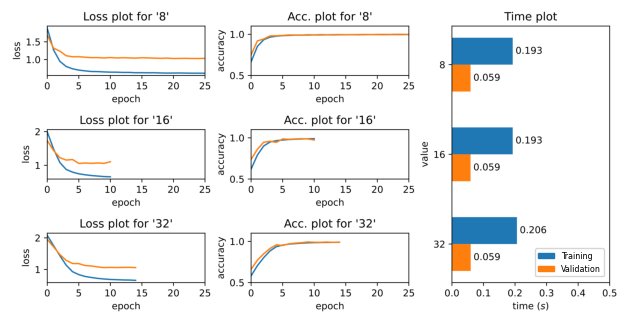

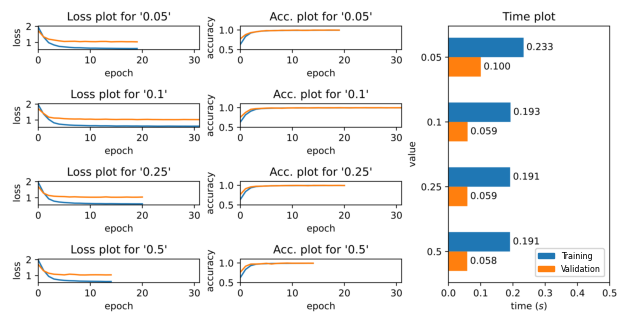

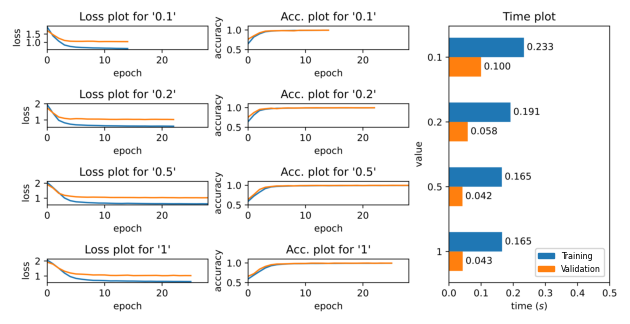

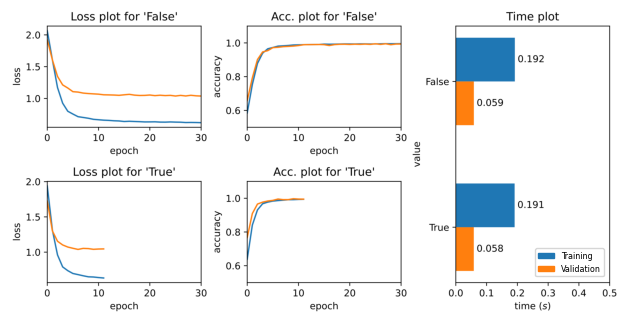

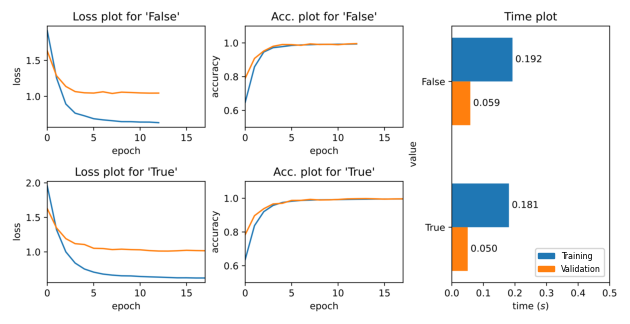

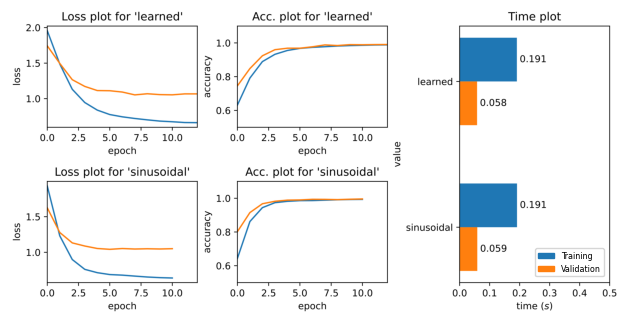

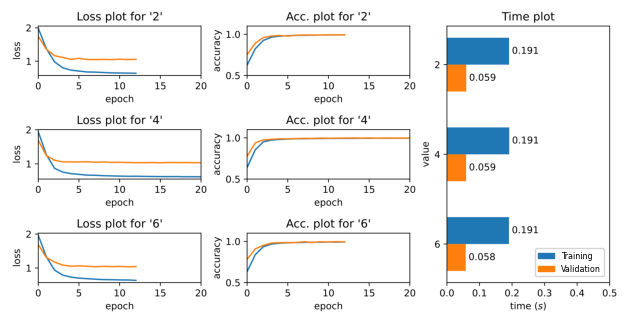

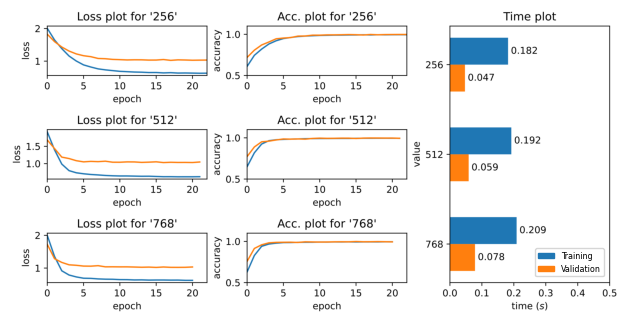

In [52]:
ablation_images_path = join("images", "ablation")
ablation_images_png_path = join("images", "ablation_png")
if not isdir(ablation_images_png_path):
    makedirs(ablation_images_png_path)
for filename in listdir(ablation_images_path):
    if not filename.endswith(".png"):
        continue
    filepath = join(ablation_images_path, filename)
    fig, ax = plt.subplots(nrows=1, ncols=1, tight_layout=True)
    plt.axis('off')
    plt.legend(handles=[
        matplotlib.patches.Patch(color='tab:blue', label='Training'),
        matplotlib.patches.Patch(color='tab:orange', label='Validation'),
    ], loc="lower right", bbox_to_anchor=(0.98, 0.11), fontsize="xx-small")
    im = Image.open(filepath)
    plt.imshow(im)
    fig.savefig(join(ablation_images_png_path, filename), bbox_inches='tight', dpi=300)

# Computational complexity

In [61]:
from thop import profile
import torch
from torch import nn
import time
import pandas as pd
from tqdm import tqdm

In [54]:
model = SATEER(
    in_channels=len(dataset.electrodes),
    sampling_rate=dataset.sampling_rate,
    labels=dataset.labels,
    labels_classes=dataset.labels_classes,

    users_embeddings=True,
    num_users=len(dataset.subject_ids),

    mels=16,
    mel_window_size=0.5,
    mel_window_stride=0.25,

    hidden_size=512,
    num_encoders=4,
    num_decoders=4,
    encoder_only=False,
    num_attention_heads=8,
    positional_embedding_type="sinusoidal",
    max_position_embeddings=2048,
    dropout_p=0.25,
    data_augmentation=False,
)

model_baseline = SATEER(
    in_channels=len(dataset.electrodes),
    sampling_rate=dataset.sampling_rate,
    labels=dataset.labels,
    labels_classes=dataset.labels_classes,

    users_embeddings=True,
    num_users=len(dataset.subject_ids),

    mels=16,
    mel_window_size=0.5,
    mel_window_stride=0.25,

    hidden_size=256,
    num_encoders=1,
    num_decoders=1,
    encoder_only=False,
    num_attention_heads=8,
    positional_embedding_type="learned",
    max_position_embeddings=2048,
    dropout_p=0.25,
    data_augmentation=False,
)

model_no_ue = SATEER(
    in_channels=len(dataset.electrodes),
    sampling_rate=dataset.sampling_rate,
    labels=dataset.labels,
    labels_classes=dataset.labels_classes,

    users_embeddings=False,
    num_users=0,

    mels=16,
    mel_window_size=0.5,
    mel_window_stride=0.25,

    hidden_size=512,
    num_encoders=4,
    num_decoders=4,
    encoder_only=False,
    num_attention_heads=8,
    positional_embedding_type="sinusoidal",
    max_position_embeddings=2048,
    dropout_p=0.25,
    data_augmentation=False,
)

model_baseline_no_ue = SATEER(
    in_channels=len(dataset.electrodes),
    sampling_rate=dataset.sampling_rate,
    labels=dataset.labels,
    labels_classes=dataset.labels_classes,

    users_embeddings=False,

    mels=16,
    mel_window_size=0.5,
    mel_window_stride=0.25,

    hidden_size=256,
    num_encoders=1,
    num_decoders=1,
    encoder_only=False,
    num_attention_heads=8,
    positional_embedding_type="learned",
    max_position_embeddings=2048,
    dropout_p=0.25,
    data_augmentation=False,
)

In [55]:
class ModelWrapper(nn.Module):
    def __init__(self, model, has_user_embeddings: bool, is_training: bool=True):
        super().__init__()
        self.model = model
        self.user_embeddings = has_user_embeddings
        self.is_training = is_training
        self.optimizer = torch.optim.AdamW(self.parameters(), lr=1e-3)
        
    def forward(self, x):
        with torch.set_grad_enabled(self.is_training):
            if self.is_training:
                self.optimizer.zero_grad()
                self.train()
            else:
                self.eval()
            if len(x.shape) == 2:
                x = x.unsqueeze(0)
            if self.user_embeddings:
                dummy_ids = ["s01"] * len(x)
                outs = self.model(input_eegs=x, ids=dummy_ids)
            else:
                outs = self.model(input_eegs=x)
            if self.is_training:
                loss = torch.nn.functional.binary_cross_entropy_with_logits(input=outs["labels_pred"], target=torch.ones_like(outs["labels_pred"]))
                loss.backward()
                self.optimizer.step()
            return outs
    
    def set_training(self, b):
        self.is_training = b
        if self.is_training:
            self.train()
        else:
            self.eval()

In [74]:
model_for_complexity = ModelWrapper(model, has_user_embeddings=True)
model_baseline_for_complexity = ModelWrapper(
    model_baseline, has_user_embeddings=True)
model_no_ue_for_complexity = ModelWrapper(
    model_no_ue, has_user_embeddings=False)
model_baseline_no_ue_for_complexity = ModelWrapper(
    model_baseline_no_ue, has_user_embeddings=False)
results = pd.DataFrame()

for batch in dataloader:
    for model_name, model_type in [
            ("model", model_for_complexity),
            ("model_baseline", model_baseline_for_complexity),
            ("model_no_ue", model_no_ue_for_complexity),
            ("model_baseline_no_ue", model_baseline_no_ue_for_complexity),
    ]:
        # inference
        for i in tqdm(range(100), desc=f"testing {model_name}"):
            st = time.time()
            with torch.no_grad():
                model_type.set_training(False)
                macs, _ = profile(model_type, inputs=batch["eegs"], verbose=False)
            inference_time = time.time() - st
            params = sum(param.numel() for param in model_type.parameters())
            results = pd.concat([results, pd.DataFrame([{
                "phase": "val",
                "model": model_name,
                "macs": macs,
                "params": params,
                "time": inference_time,
            }])], axis=0, ignore_index=True)
            
            # training
            st = time.time()
            model_type.set_training(True)
            macs, _ = profile(model_type, inputs=batch["eegs"], verbose=False)
            training_time = time.time() - st
            params = sum(param.numel() for param in model_type.parameters())
            results = pd.concat([results, pd.DataFrame([{
                "phase": "train",
                "model": model_name,
                "macs": macs,
                "params": params,
                "time": training_time,
            }])], axis=0, ignore_index=True)
    break

100%|██████████| 100/100 [00:01<00:00, 54.10it/s]


In [84]:
results
print(results.groupby(["model", "phase"]).mean())


                                   macs      params      time
model                phase                                   
model                train  307408896.0  29712904.0  0.082890
                     val    307408896.0  29712904.0  0.020605
model_baseline       train    7108608.0   3559688.0  0.013006
                     val      7108608.0   3559688.0  0.004874
model_baseline_no_ue train    6055936.0   3550728.0  0.012277
                     val      6055936.0   3550728.0  0.004707
model_no_ue          train   85659648.0  29694984.0  0.069666
                     val     85659648.0  29694984.0  0.015448
                            macs  params      time
model                phase                        
model                train   0.0     0.0  0.043239
                     val     0.0     0.0  0.003334
model_baseline       train   0.0     0.0  0.005057
                     val     0.0     0.0  0.001157
model_baseline_no_ue train   0.0     0.0  0.003405
                     va

In [ ]:
results.groupby(["model", "phase"]).std()